In [12]:
import glob
import sys, os
import time, pickle
import re
from ete3 import NCBITaxa
sys.path.append("/Users/chilpert/Dev/pyproteinsExt/src")
sys.path.append("/Users/chilpert/Dev/pyproteins/src")
import pyproteinsExt.topology as topology
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def save(data, tag=None):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fTag = "NOX_annotation_" + tag + "_" if tag else "NOX_annotation_"
    fSerialDump = fTag + timestr + ".pickle"
    with open(saveDir + '/' + fSerialDump, 'wb') as f:
        pickle.dump(data, f)
    print('data structure saved to', saveDir + '/' + fSerialDump)

def load(fileName):
    saveDir="/Volumes/arwen/mobi/group/NOX_clean/pickle_saved"
    d = pickle.load( open(saveDir + "/" + fileName, "rb" ) )
    print("restore a annotated container of ", len(d), "elements")
    return d

## Raw Pfam domains

First, NOX signature search is done by using Pfam domains corresponding to FAD_binding, NAD_binding and Ferric_reduct

#### Preliminary work 
Starting from complete trEMBL dataset `arwen:/mobi/group/databases/flat/uniprot_trembl_2019_02.fasta.gz`
 *  Split the dataset in small volumes
     * script: <span style="color:green">**split.py**</span>
     * Usage:
     Create and go to the 
```console
    mkdir /mobi/group/NOX_clean/volumes_trembl
    cd /mobi/group/NOX_clean/volumes_trembl
    ROOT_DIR=/mobi/group/NOX_clean
    SCRIPT_DIR=/mobi/group/NOX_clean/nox-analysis/scripts
    python $SCRIPT_DIR/split.py /mobi/group/databases/flat/uniprot_trembl_2019_02.fasta.gz
```

* Run the HMMR and TMHMM annotations
    * script: <span style="color:green">**runHMMR_slurm.sh**</span>
    * Usage:  
  
```console
    mkdir $ROOT_DIR/initial_work
    $SCRIPT_DIR/runHMMR_slurm.sh $ROOT_DIR/volumes_trembl $ROOT_DIR/initial_work $ROOT_DIR/data/profiles
```

### Parse hmmr, tmhmm and fasta

In [51]:
def parsing_results(dataDir):
    dataDir_length=len(dataDir)
    c=1
    print(c,"/",dataDir_length)
    dataContainer=topology.parse(hmmrOut=dataDir[0]+"/hmmsearch.out",tmhmmOut=dataDir[0]+"/tmhmm.out",fastaOut=dataDir[0]+"/hmmsearch.fasta")
    for dir in dataDir[1:]:
        c+=1
        if c%10==0:
            print(c,"/",dataDir_length)
        dataContainer=dataContainer.addParsing(topology.parse(hmmrOut=dir+"/hmmsearch.out",tmhmmOut=dir+"/tmhmm.out",fastaOut=dir+"/hmmsearch.fasta"))
    return dataContainer

In [15]:
dataDir=glob.glob('/Volumes/arwen/mobi/group/NOX_clean/work/initial_work/uniprot_trembl_v*')
dataContainer=parsing_results(dataDir)

1 / 293
10 / 293
20 / 293
30 / 293
40 / 293
50 / 293
60 / 293
70 / 293
80 / 293
90 / 293
100 / 293
110 / 293
120 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


130 / 293
140 / 293
150 / 293
160 / 293
170 / 293
180 / 293
190 / 293
200 / 293
210 / 293
220 / 293
230 / 293
240 / 293
250 / 293
260 / 293
270 / 293
280 / 293
290 / 293


### Create filters

In [24]:
def filter_three_domains(entry): 
    '''Filter proteins that contains 3 domains'''
    domains=set([hmm_obj.domain for hmm_obj in entry.hmmr])
    if len(domains)==3:
        return True
    return False

def filter_nb_helix(entry,**kwargs):
    '''Filter proteins that have between min_helix and max_helix transmembrane helix'''
    min_helix=kwargs["min_helix"]
    max_helix=kwargs["max_helix"]
    if entry.tmhmm.nb_helix>=min_helix and entry.tmhmm.nb_helix<=max_helix:
        return True 
    return False

def filter_bi_histidine(entry):
    '''
    Filter proteins that have the bi-histidine pattern. Bi-histidine pattern is when we have 2 histidines separate
    by 12 to 14 residues, in 2 distinct helixes. 
    '''
    seq=entry.fasta.seq
    topo_seq=entry.tmhmm.topology_seq
    H_status = []
    if len(topo_seq)!=len(seq):
        raise Exception("Topology seq and amino acids seq with different size. Check !")
    for i in range(len(seq)):
        if topo_seq[i]=="i" or topo_seq[i]=="o":
            continue
        if not seq[i]=="H":
            continue
        H_status.append( [i, topo_seq[i], False] )     
    for i in range (len(H_status) - 1):
        for j in range (i + 1, len(H_status)):
            if H_status[i][1] != H_status[j][1]:
                continue
            d = H_status[j][0] - H_status[i][0]
            if d >= 12 and d <= 14:
                H_status[i][2] = True
                
    # Only keep marked histidine
    H_status = [ x for x in H_status if x[2] ]
    # Create a dicitinary where keys are Helices numbers
    H_groups = {}
    for x in H_status:
        if not x[2]:
            continue
        if x[1] not in H_groups:
            H_groups[x[1]]=[]
        H_groups[x[1]].append(x)
        
    # The test is passed if at least two distinct helices feature at least one correctly spaced histidine pair
    # ie : if the helice dictionary has more than 1 entrie
    HisTestBool = True if len(H_groups) > 1 else False     
    return HisTestBool

ncbi = NCBITaxa()
def filter_eukaryotic_header(entry):
    '''Discard eukaryotic proteins'''
    try:
        lineage=ncbi.get_lineage(entry.taxo.taxid)
        lineage_rank=ncbi.get_rank(lineage)
        superkingdom=[taxid for taxid in lineage_rank if lineage_rank[taxid]=='superkingdom']
        if superkingdom:
            name=ncbi.get_taxid_translator(superkingdom)[superkingdom[0]]
            if name == "Eukaryota":
                return False
            else:
                return True
        else: 
            return False
    except ValueError: 
        print(entry.taxo.taxid,"not found")
        return False

def filter_evalue(entry,**kwargs):
    '''Just keep proteins that have an evalue <= threshold for all domains'''
    threshold=kwargs["threshold"]
    conserve=0
    domains=set()
    for h in entry.hmmr: 
        if float(h.hit.iEvalue) <= threshold:
            domains.add(h.domain)
    if len(domains)==3:
        return True
    return False     

def filter_evalue_hit(hit,**kwargs):
    '''Don't keep hit inside hmm hits whith evalue > threshold''' 
    threshold=kwargs["threshold"]
    if float(hit.hit.iEvalue)<=threshold: 
        return True 
    return False

def function_get_taxid(e):
    taxid = e.fasta.header.split("OX=")[1].split(" ")[0]
    return taxid

def filter_NOX(data_container):
    print("Initial proteins :", len(data_container))
    '''All filters function to get predicted NOX proteins'''
    #3 domains 
    filterThreeDomains=data_container.filter(filter_three_domains)
    print("Number of proteins with 3 domains : ",len(filterThreeDomains))

    # Helix filter
    filterHelix=filterThreeDomains.filter(filter_nb_helix,min_helix=2,max_helix=7).filter(filter_bi_histidine)
    print("Number of proteins after helix filter : ",len(filterHelix))

    # Eukaryotic filter 
    for e in filterHelix: 
        e.set_taxo(function_get_taxid)
    
    filterNoEukaryotic=filterHelix.filter(filter_eukaryotic_header)
    print("Number of non-eukaryotic proteins :",len(filterNoEukaryotic))

    #Evalue 1e-3 filter 
    filterEvalue3=filterNoEukaryotic.filter(filter_evalue,threshold=1e-3).filter_hit(filter_evalue_hit,threshold=1e-3)
    print("Number of non-eukaryotic proteins after evalue 1e-3 filter :",len(filterEvalue3))
    return filterEvalue3

### Filter proteins

In [25]:
dataFiltered = filter_NOX(dataContainer)

Initial proteins : 178540
Number of proteins with 3 domains :  18020
Number of proteins after helix filter :  3257
1246674 not found
2109339 not found
2109339 not found
2109339 not found
Number of non-eukaryotic proteins : 701
Number of non-eukaryotic proteins after evalue 1e-3 filter : 136


### Save NOX predicted proteins

In [33]:
save(dataFiltered,"global_profile")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_global_profile_20190808-144805.pickle


## Refine Pfam domains

Re-annotate by using new Pfam domains, created with only prokaryote domain sequences

### Write domain sequences in multifasta, from filtered proteins at 1e-3

In [27]:
mfasta_nad=dataFiltered.get_domain_mfasta("PF08030_full")
mfasta_fad=dataFiltered.get_domain_mfasta("PF08022_full")
mfasta_ferric=dataFiltered.get_domain_mfasta("PF01794_full")

In [28]:
nad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/1/nad_binding_prokaryotes.mfasta"
fad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/1/fad_binding_prokaryotes.mfasta"
ferric_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/1/ferric_reduct_prokaryotes.mfasta"

In [29]:
o=open(nad_output,"w")
o.write(mfasta_nad)
o.close()
o=open(fad_output,"w")
o.write(mfasta_fad)
o.close()
o=open(ferric_output,"w")
o.write(mfasta_ferric)
o.close()

### Create new hmm profiles

```console
WORKDIR=/mobi/group/NOX_clean/refined_profiles/1
module load clustalw
module load hmmr

cd $WORKDIR 
for p in fad_binding nad_binding ferric_reduct; do 
    clustalw2 -INFILE=$p\_prokaryotes.mfasta -OUTFILE=$p\_multiple_alignment.clustal;
    hmmbuild -n $p\_prokaryotes $p\_prokaryotes.hmm $p\_multiple_alignment.clustal;
done
```

### Search NOX proteins with refined pfam domains

* Prepare environment
```console 
WORKDIR=/mobi/group/NOX_clean
mkdir $WORKDIR/data/refined_profiles
ln -s $WORKDIR/refined_profiles/1/fad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles/fad_binding.hmm
ln -s $WORKDIR/refined_profiles/1/nad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles/nad_binding.hmm
ln -s $WORKDIR/refined_profiles/1/ferric_reduct_prokaryotes.hmm $WORKDIR/data/refined_profiles/ferric_reduct.hmm
mkdir $WORKDIR/refined1_work
```

* Run hmm and tmhmm
```console
SCRIPT_DIR=/mobi/group/NOX_clean/nox-analysis/scripts
$SCRIPT_DIR/runHMMR_slurm.sh $WORKDIR/volumes_trembl $WORKDIR/refined1_work $WORKDIR/data/refined_profiles
```

### Filter proteins

In [30]:
dataDir_refined=glob.glob('/Volumes/arwen/mobi/group/NOX_clean/work/refined1_work/uniprot_trembl_v*')

In [31]:
dataContainer_refined=parsing_results(dataDir_refined)

1 / 293
10 / 293
20 / 293
30 / 293
40 / 293
50 / 293
60 / 293
70 / 293
80 / 293
90 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


100 / 293
110 / 293
120 / 293
130 / 293
140 / 293
150 / 293
160 / 293
170 / 293
180 / 293
190 / 293
200 / 293
210 / 293
220 / 293
230 / 293
240 / 293
250 / 293
260 / 293
270 / 293
280 / 293
290 / 293


In [32]:
filterEvalue3_refined=filter_NOX(dataContainer_refined)

Initial proteins : 190820
Number of proteins with 3 domains :  14483
Number of proteins after helix filter :  2848
1246674 not found
2109339 not found
2109339 not found
Number of non-eukaryotic proteins : 816
Number of non-eukaryotic proteins after evalue 1e-3 filter : 777


In [34]:
save(filterEvalue3_refined,"refined1")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_refined1_20190808-144810.pickle


### Compare before and after refined profiles

In [35]:
global_profile=load("NOX_annotation_global_profile_20190808-144805.pickle")
refined1_profile=load("NOX_annotation_refined1_20190808-144810.pickle")

restore a annotated container of  136 elements
restore a annotated container of  777 elements


In [36]:
proteins_global=set([p.split("|")[1] for p in global_profile.entries])
proteins_refined=set([p.split("|")[1] for p in refined1_profile.entries])

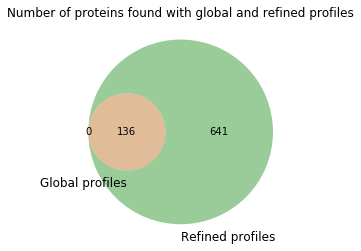

In [37]:
v=venn2([proteins_global,proteins_refined])
v.get_label_by_id("A").set_text("Global profiles")
v.get_label_by_id("B").set_text("Refined profiles")
plt.title("Number of proteins found with global and refined profiles")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/prot_global_refined_profiles.pdf")

All proteins found with global profiles are also found with refined profiles and we have 777 more proteins with refined profiles

## Refine profiles 2

In [38]:
mfasta_nad=refined1_profile.get_domain_mfasta("nad_binding_prokaryotes")
mfasta_fad=refined1_profile.get_domain_mfasta("fad_binding_prokaryotes")
mfasta_ferric=refined1_profile.get_domain_mfasta("ferric_reduct_prokaryotes")

In [39]:
nad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/2/nad_binding_prokaryotes.mfasta"
fad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/2/fad_binding_prokaryotes.mfasta"
ferric_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/2/ferric_reduct_prokaryotes.mfasta"

In [40]:
o=open(nad_output,"w")
o.write(mfasta_nad)
o.close()
o=open(fad_output,"w")
o.write(mfasta_fad)
o.close()
o=open(ferric_output,"w")
o.write(mfasta_ferric)
o.close()

```console
WORKDIR=/mobi/group/NOX_clean/refined_profiles/2
module load clustalw
module load hmmr

cd $WORKDIR 
for p in fad_binding nad_binding ferric_reduct; do 
    clustalw2 -INFILE=$p\_prokaryotes.mfasta -OUTFILE=$p\_multiple_alignment.clustal;
    hmmbuild -n $p\_prokaryotes $p\_prokaryotes.hmm $p\_multiple_alignment.clustal;
done
```


* Prepare environment
```console 
WORKDIR=/mobi/group/NOX_clean
mkdir -p $WORKDIR/data/refined_profiles_2
ln -s $WORKDIR/refined_profiles/2/fad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_2/fad_binding.hmm
ln -s $WORKDIR/refined_profiles/2/nad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_2/nad_binding.hmm
ln -s $WORKDIR/refined_profiles/2/ferric_reduct_prokaryotes.hmm $WORKDIR/data/refined_profiles_2/ferric_reduct.hmm
mkdir -p $WORKDIR/refined2_work
```

* Run hmm and tmhmm
```console
$SCRIPT_DIR/runHMMR_slurm.sh $WORKDIR/volumes_trembl $WORKDIR/refined2_work $WORKDIR/data/refined_profiles_2
```

In [41]:
dataDir=glob.glob('/Volumes/arwen/mobi/group/NOX_clean/work/refined2_work/uniprot_trembl_v*')
dataContainer_refined2=parsing_results(dataDir)

1 / 293
10 / 293
20 / 293
30 / 293
40 / 293
50 / 293
60 / 293
70 / 293
80 / 293
90 / 293
100 / 293
110 / 293
120 / 293
130 / 293
140 / 293
150 / 293
160 / 293
170 / 293
180 / 293
190 / 293
200 / 293
210 / 293
220 / 293
230 / 293
240 / 293
250 / 293
260 / 293
270 / 293
280 / 293
290 / 293


In [42]:
refined2_filter=filter_NOX(dataContainer_refined2)

Initial proteins : 185444
Number of proteins with 3 domains :  13635
Number of proteins after helix filter :  2831
1246674 not found
2109339 not found
2109339 not found
Number of non-eukaryotic proteins : 821
Number of non-eukaryotic proteins after evalue 1e-3 filter : 805


In [ ]:
save(refined2_filter,"refined2")

### Comparison with proteins found with previous refined profiles

In [45]:
refined1=load("NOX_annotation_refined1_20190808-144810.pickle")
refined2=load("NOX_annotation_refined2_20190808-151117.pickle")

restore a annotated container of  777 elements
restore a annotated container of  805 elements


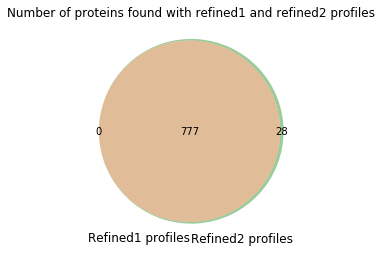

In [47]:
v=venn2([refined1_proteins,refined2_proteins])
v.get_label_by_id("A").set_text("Refined1 profiles")
v.get_label_by_id("B").set_text("Refined2 profiles")
plt.title("Number of proteins found with refined1 and refined2 profiles")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/prot_refined12_profiles.pdf")

## Refined profile 3

In [48]:
mfasta_nad=refined2.get_domain_mfasta("nad_binding_prokaryotes")
mfasta_fad=refined2.get_domain_mfasta("fad_binding_prokaryotes")
mfasta_ferric=refined2.get_domain_mfasta("ferric_reduct_prokaryotes")

In [49]:
nad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/3/nad_binding_prokaryotes.mfasta"
fad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/3/fad_binding_prokaryotes.mfasta"
ferric_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/3/ferric_reduct_prokaryotes.mfasta"

In [50]:
o=open(nad_output,"w")
o.write(mfasta_nad)
o.close()
o=open(fad_output,"w")
o.write(mfasta_fad)
o.close()
o=open(ferric_output,"w")
o.write(mfasta_ferric)
o.close()

```console
WORKDIR=/mobi/group/NOX_clean/refined_profiles/3
module load clustalw
module load hmmr

cd $WORKDIR 
for p in fad_binding nad_binding ferric_reduct; do 
    clustalw2 -INFILE=$p\_prokaryotes.mfasta -OUTFILE=$p\_multiple_alignment.clustal;
    hmmbuild -n $p\_prokaryotes $p\_prokaryotes.hmm $p\_multiple_alignment.clustal;
done
```


* Prepare environment
```console 
WORKDIR=/mobi/group/NOX_clean
mkdir -p $WORKDIR/data/refined_profiles_3
ln -s $WORKDIR/refined_profiles/3/fad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_3/fad_binding.hmm
ln -s $WORKDIR/refined_profiles/3/nad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_3/nad_binding.hmm
ln -s $WORKDIR/refined_profiles/3/ferric_reduct_prokaryotes.hmm $WORKDIR/data/refined_profiles_3/ferric_reduct.hmm
mkdir -p $WORKDIR/refined3_work
```

* Run hmm and tmhmm
```console
$SCRIPT_DIR/runHMMR_slurm.sh $WORKDIR/volumes_trembl $WORKDIR/refined3_work $WORKDIR/data/refined_profiles_3
```

In [51]:
dataDir=glob.glob('/Volumes/arwen/mobi/group/NOX_clean/work/refined3_work/uniprot_trembl_v*')
dataRefined3=parsing_results(dataDir)

1 / 293
10 / 293
20 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


30 / 293
40 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


   [No individual domains that satisfy reporting thresholds (although complete target did)]


50 / 293
60 / 293
70 / 293
80 / 293
90 / 293
100 / 293
110 / 293
120 / 293
130 / 293
140 / 293
150 / 293
160 / 293
170 / 293
180 / 293
190 / 293
200 / 293
210 / 293
220 / 293
230 / 293
240 / 293
250 / 293
260 / 293
270 / 293
280 / 293
290 / 293


In [52]:
refined_filter3=filter_NOX(dataRefined3)

Initial proteins : 174397
Number of proteins with 3 domains :  11349
Number of proteins after helix filter :  2438
1246674 not found
2109339 not found
2109339 not found
Number of non-eukaryotic proteins : 815
Number of non-eukaryotic proteins after evalue 1e-3 filter : 804


In [53]:
save(refined_filter3,"refined3")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_refined3_20190808-152927.pickle


#### Compare 

In [54]:
dataRefined2=load("NOX_annotation_refined2_20190808-151117.pickle")
dataRefined3=load("NOX_annotation_refined3_20190808-152927.pickle")

restore a annotated container of  805 elements
restore a annotated container of  804 elements


In [55]:
refined2_proteins=set(p.split('|')[1] for p in dataRefined2.entries)
refined3_proteins=set(p.split('|')[1] for p in dataRefined3.entries)

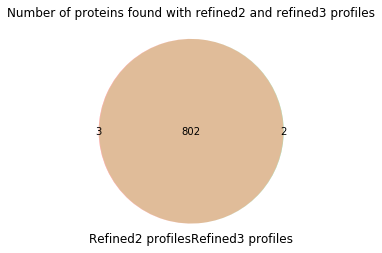

In [56]:
v=venn2([refined2_proteins,refined3_proteins])
v.get_label_by_id("A").set_text("Refined2 profiles")
v.get_label_by_id("B").set_text("Refined3 profiles")
plt.title("Number of proteins found with refined2 and refined3 profiles")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/prot_refined23_profiles.pdf")

In [57]:
common = refined2_proteins.intersection(refined3_proteins)
refined2_specific = refined2_proteins.difference(refined3_proteins)
refined3_specific = refined3_proteins.difference(refined2_proteins)
all_proteins = refined2_proteins.union(refined3_proteins)
print(len(all_proteins))

807


On a 802 protéines en commun avec le profil précédent (refined2), 3 sont spécifiques à Refined2, 2 spécifiques à Refined3. 807 protéines si on prends celles de refined2 et refined3

In [58]:
allContainer = dataRefined2 + dataRefined3
save(allContainer, "refined23")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_refined23_20190808-153047.pickle


## Refined profiles 4

In [59]:
mfasta_nad=allContainer.get_domain_mfasta("nad_binding_prokaryotes")
mfasta_fad=allContainer.get_domain_mfasta("fad_binding_prokaryotes")
mfasta_ferric=allContainer.get_domain_mfasta("ferric_reduct_prokaryotes")

In [60]:
nad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/4/nad_binding_prokaryotes.mfasta"
fad_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/4/fad_binding_prokaryotes.mfasta"
ferric_output="/Volumes/arwen/mobi/group/NOX_clean/refined_profiles/4/ferric_reduct_prokaryotes.mfasta"

In [61]:
o=open(nad_output,"w")
o.write(mfasta_nad)
o.close()
o=open(fad_output,"w")
o.write(mfasta_fad)
o.close()
o=open(ferric_output,"w")
o.write(mfasta_ferric)
o.close()

```console
WORKDIR=/mobi/group/NOX_clean/refined_profiles/4
mkdir -p $WORKDIR
module load clustalw
module load hmmr

cd $WORKDIR 
for p in fad_binding nad_binding ferric_reduct; do 
    clustalw2 -INFILE=$p\_prokaryotes.mfasta -OUTFILE=$p\_multiple_alignment.clustal;
    hmmbuild -n $p\_prokaryotes $p\_prokaryotes.hmm $p\_multiple_alignment.clustal;
done
```


* Prepare environment
```console 
WORKDIR=/mobi/group/NOX_clean
mkdir -p $WORKDIR/data/refined_profiles_4
ln -s $WORKDIR/refined_profiles/4/fad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_4/fad_binding.hmm
ln -s $WORKDIR/refined_profiles/4/nad_binding_prokaryotes.hmm $WORKDIR/data/refined_profiles_4/nad_binding.hmm
ln -s $WORKDIR/refined_profiles/4/ferric_reduct_prokaryotes.hmm $WORKDIR/data/refined_profiles_4/ferric_reduct.hmm
mkdir -p $WORKDIR/refined4_work
```

* Run hmm and tmhmm
```console
$SCRIPT_DIR/runHMMR_slurm.sh $WORKDIR/volumes_trembl $WORKDIR/refined4_work $WORKDIR/data/refined_profiles_4
```

In [62]:
dataDir = glob.glob("/Volumes/arwen/mobi/group/NOX_clean/work/refined4_work/uniprot_trembl_v*")
dataRefined4 = parsing_results(dataDir)

1 / 293
10 / 293
20 / 293
30 / 293
40 / 293
50 / 293
60 / 293
70 / 293
80 / 293
90 / 293
100 / 293
110 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


120 / 293
130 / 293
140 / 293
150 / 293
160 / 293
170 / 293
180 / 293
190 / 293
200 / 293
210 / 293
220 / 293
   [No individual domains that satisfy reporting thresholds (although complete target did)]


230 / 293
240 / 293
250 / 293
260 / 293
270 / 293
280 / 293
290 / 293


In [63]:
dataFiltered4 = filter_NOX(dataRefined4)

Initial proteins : 187599
Number of proteins with 3 domains :  12569
Number of proteins after helix filter :  2598
1246674 not found
2109339 not found
2109339 not found
Number of non-eukaryotic proteins : 817
Number of non-eukaryotic proteins after evalue 1e-3 filter : 806


In [85]:
save(dataFiltered4, "refined4")

data structure saved to /Volumes/arwen/mobi/group/NOX_clean/pickle_saved/NOX_annotation_refined4_20190807-121615.pickle


In [86]:
previous_data = load("NOX_annotation_refined4_20190807-121615.pickle")

restore a annotated container of  976 elements


In [87]:
previous_proteins=set(p.split('|')[1] for p in previous_data.entries)
now_proteins=set(p.split('|')[1] for p in dataFiltered4.entries)

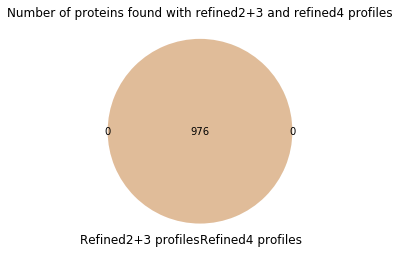

In [88]:
v=venn2([previous_proteins,now_proteins])
v.get_label_by_id("A").set_text("Refined2+3 profiles")
v.get_label_by_id("B").set_text("Refined4 profiles")
plt.title("Number of proteins found with refined2+3 and refined4 profiles")
plt.savefig("/Users/chilpert/Results/NOX_visu_clean/prot_refined234_profiles.pdf")

No proteins specific to refined4 profiles. The final proteins set is 977 proteins from refined2 and refined3 profiles

In [89]:
finalSet = load("NOX_annotation_refined23_20190807-120613.pickle")
mfasta = finalSet.proteins_mfasta()
o=open("/Volumes/arwen/mobi/group/NOX_clean/predicted_NOX_proteins_final.mfasta",'w')
o.write(mfasta)
o.close()

restore a annotated container of  977 elements


## Proteins distribution in taxonomy

In [90]:
import subprocess

In [91]:
o=open("/Volumes/arwen/mobi/group/NOX_clean/results/taxonomy/proteins_taxonomy_taxid_krona.tsv","w")
o.write("#protein\ttaxid\tscore\n")
for e in finalSet : 
    o.write(e.prot+"\t"+e.taxo.taxid+"\t1\n")
o.close()

In [92]:
#Run kronaTools
import subprocess
subprocess.run(['ktImportTaxonomy','/Volumes/arwen/mobi/group/NOX_clean/results/taxonomy/proteins_taxonomy_taxid_krona.tsv','-o','/Users/chilpert/Results/NOX_visu_clean/NOX_taxo_krona.html'])

CompletedProcess(args=['ktImportTaxonomy', '/Volumes/arwen/mobi/group/NOX_clean/results/taxonomy/proteins_taxonomy_taxid_krona.tsv', '-o', '/Users/chilpert/Results/NOX_visu_clean/NOX_taxo_krona.html'], returncode=0)